# Import Libraries

In [6]:
! pip install pyvi

In [7]:
import pandas as pd
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM, Input, GlobalAveragePooling1D, Flatten, GRU, LayerNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pyvi import ViTokenizer
from pyvi import ViUtils

# Data

### Load Data

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
data_path = "/content/drive/MyDrive/Colab Notebooks/data.csv"
data = pd.read_csv(data_path)
data.head()

,Comment Text,Manual label
0,"Trời ơi quá trời bà gòi Trần Gia Hảo, rửa đii",1.0
1,Quá dữ luôn :3,1.0
2,coi teaser thoi mà trái tym tan nát 😢,0.0
3,Yến Nhi Phạm Tuấn Phong ủa nhìn 2 ac giống tro...,2.0
4,Quá tuyệt,1.0


In [10]:
sentiment_data = pd.DataFrame({'input': data['Comment Text'], 'label': data['Manual label']})
sentiment_data = sentiment_data.dropna()
sentiment_data = sentiment_data.reset_index(drop=True)
sentiment_data.head()

,input,label
0,"Trời ơi quá trời bà gòi Trần Gia Hảo, rửa đii",1.0
1,Quá dữ luôn :3,1.0
2,coi teaser thoi mà trái tym tan nát 😢,0.0
3,Yến Nhi Phạm Tuấn Phong ủa nhìn 2 ac giống tro...,2.0
4,Quá tuyệt,1.0


### Preprocessing Data

In [11]:
input_data = sentiment_data['input'].values
input_label = sentiment_data['label'].values

label_dict = {'NEG':0, 'NEU':1, 'POS':2}

input_pre = []
label_with_accent = []
for idx, dt in enumerate(input_data):
  input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(dt))
  input_text_pre = " ".join(input_text_pre)
  input_text_pre_no_accent = str(ViUtils.remove_accents(input_text_pre).decode("utf-8"))
  input_text_pre_accent = ViTokenizer.tokenize(input_text_pre)
  input_text_pre_no_accent = ViTokenizer.tokenize(input_text_pre_no_accent)
  input_pre.append(input_text_pre_accent)
  input_pre.append(input_text_pre_no_accent)
  label_with_accent.append(input_label[idx])
  label_with_accent.append(input_label[idx])

### PLot Dataset

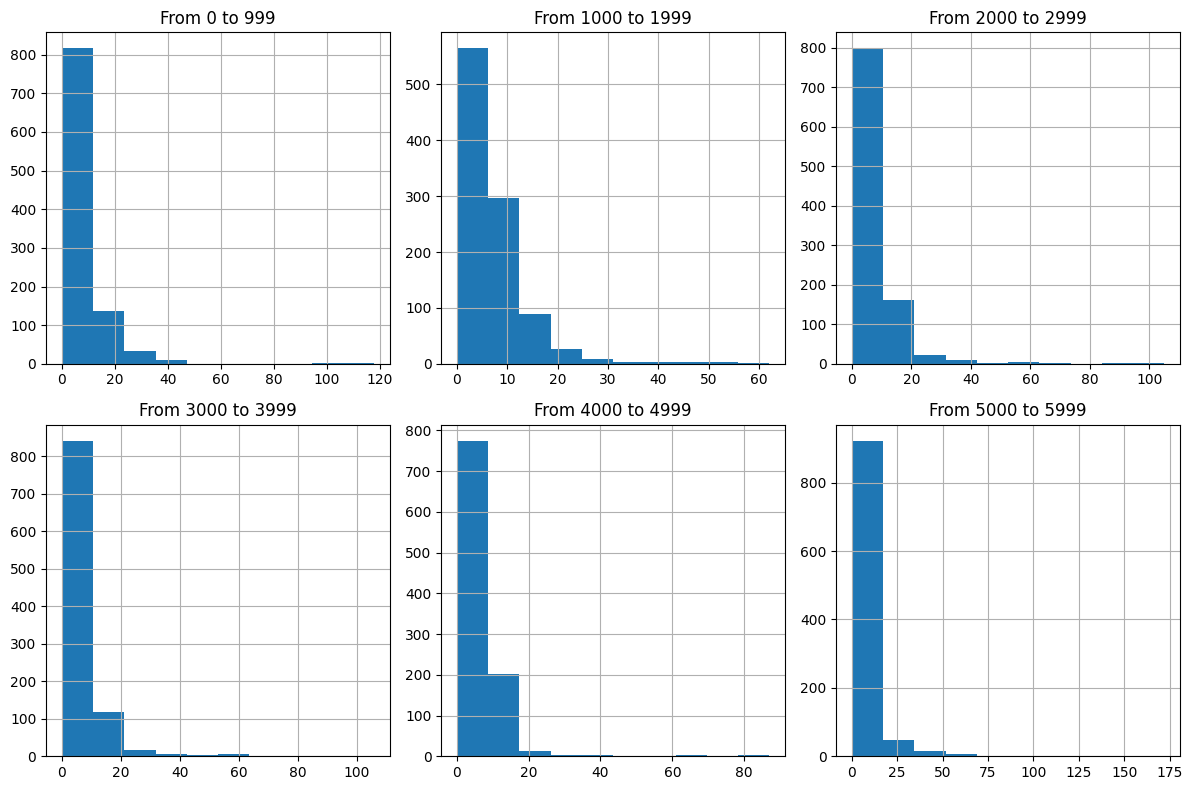

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, ax in enumerate(axes.ravel()):
  start_idx = i * 1000
  end_idx = (i + 1) * 1000
  seq_len = [len(j.split()) for j in input_pre[start_idx:end_idx]]
  pd.Series(seq_len).hist(bins=10, ax=ax)
  ax.set_title(f'From {start_idx} to {end_idx-1}')

plt.tight_layout()
plt.show()

In [13]:
# seq_len = [len(i.split()) for i in input_pre[0:1000]]
# pd.Series(seq_len).hist(bins = 10, figsize=(20,15))
# plt.show()

# seq_len = [len(i.split()) for i in input_pre[1000:2000]]
# pd.Series(seq_len).hist(bins = 10)
# plt.show()

# seq_len = [len(i.split()) for i in input_pre[2000:3000]]
# pd.Series(seq_len).hist(bins = 10)
# plt.show()

# seq_len = [len(i.split()) for i in input_pre[3000:4000]]
# pd.Series(seq_len).hist(bins = 10)
# plt.show()

# seq_len = [len(i.split()) for i in input_pre[4000:5000]]
# pd.Series(seq_len).hist(bins = 10)

# plt.tight_layout()
# plt.show()

### Data shape

In [14]:
label_idx = [i for i in label_with_accent]
label_tf = tf.keras.utils.to_categorical(label_idx, num_classes = 3, dtype = 'float32')

tokenizer_data = Tokenizer(oov_token = '<OOV>', filters = '', split = ' ')
tokenizer_data.fit_on_texts(input_pre)

tokenized_data_text = tokenizer_data.texts_to_sequences(input_pre)
vec_data = pad_sequences(tokenized_data_text, padding = 'post', maxlen = 800)

# Save model to pickle file
pickle.dump(tokenizer_data, open("tokenizer_data.pkl", "wb"))

print('input data.shape', vec_data.shape)
data_vocab_size = len(tokenizer_data.word_index)+1
print('data_vocab_size: ', data_vocab_size)


X_train, X_val, y_train, y_val = train_test_split(vec_data, label_tf, test_size = 0.2, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.1, random_state = 42)
print('training sample: ', len(X_train))
print('validation sample: ', len(X_val))
print('test_sample: ', len(X_test))

input data.shape (96368, 800)
data_vocab_size:  34120
training sample:  69384
validation sample:  19274
test_sample:  7710


# Model

### Architechture

In [15]:
from keras.layers import MaxPooling1D,Conv1D, GlobalMaxPooling1D
from unicodedata import bidirectional
def generate_model():
  dropout_threshold = 0.4
  input_dim = data_vocab_size
  output_dim = 50
  input_length = 800
  initializer = tf.keras.initializers.GlorotNormal()

  input_layer = Input(shape = (input_length))
  feature = Embedding(input_dim = input_dim, output_dim = output_dim, input_length = input_length, embeddings_initializer = 'GlorotNormal')(input_layer)

  cnn_feature = Conv1D(filters = 50, kernel_size = 3, padding = 'same', activation = 'relu')(feature)
  cnn_feature = MaxPooling1D()(cnn_feature)
  cnn_feature = Dropout(dropout_threshold)(cnn_feature)
  cnn_feature = Conv1D(filters = 50, kernel_size = 3, padding = 'same', activation = 'relu')(cnn_feature)
  cnn_feature = MaxPooling1D()(cnn_feature)
  cnn_feature = LayerNormalization()(cnn_feature)
  cnn_feature = Dropout(dropout_threshold)(cnn_feature)


  bi_lstm_feature = Bidirectional(LSTM(units = 50, dropout = dropout_threshold, return_sequences = True, kernel_initializer = initializer), merge_mode = 'concat')(feature)
  bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)

  bi_lstm_feature = Bidirectional(GRU(units = 50, dropout = dropout_threshold, return_sequences = True, kernel_initializer = initializer), merge_mode = 'concat')(bi_lstm_feature)
  bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)
  bi_lstm_feature = LayerNormalization()(bi_lstm_feature)

  combine_feature = tf.keras.layers.Concatenate()([cnn_feature, bi_lstm_feature])
  combine_feature = GlobalMaxPooling1D()(combine_feature)
  combine_feature = LayerNormalization()(combine_feature)

  classifier = Dense(90, activation = 'relu')(combine_feature)
  classifier = Dropout(0, 2)(classifier)
  classifier = Dense(70, activation = 'relu')(classifier)
  classifier = Dropout(0, 2)(classifier)
  classifier = Dense(50, activation = 'relu')(classifier)
  classifier = Dropout(0, 2)(classifier)
  classifier = Dense(30, activation = 'relu')(classifier)
  classifier = Dropout(0, 2)(classifier)
  classifier = Dense(3, activation = 'softmax')(classifier)

  model = tf.keras.Model(inputs = input_layer, outputs = classifier)

  return model

model = generate_model()
adam = Adam(learning_rate = 0.001)
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 800)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 800, 50)      1706000     ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 800, 50)      7550        ['embedding[0][0]']              
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 400, 50)      0           ['conv1d[0][0]']                 
                                                                                              

### Architechture Visualization

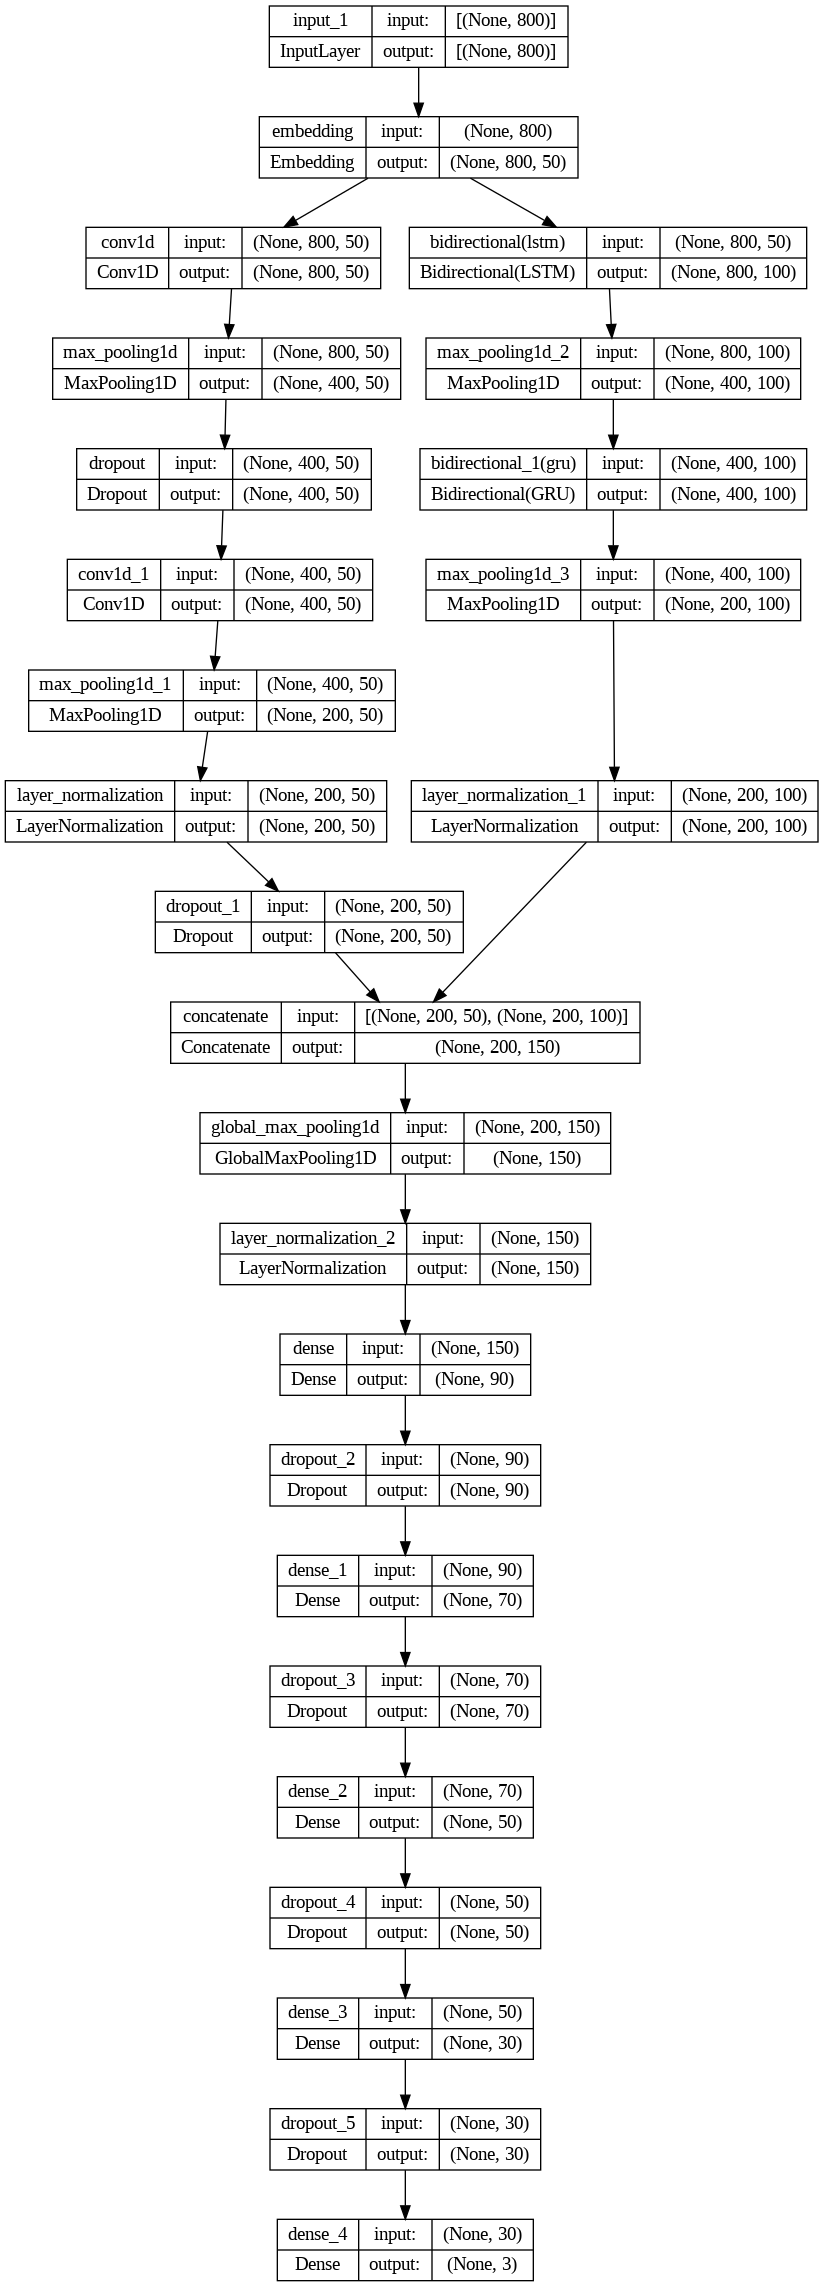

In [16]:
dot_img_file = 'model_visualize.png'
tf.keras.utils.plot_model(model, to_file = dot_img_file, show_shapes = True)

### Train

In [17]:
callback_model = tf.keras.callbacks.ModelCheckpoint('model_cnn_bilstm.h5', monitor = 'val_loss')
history = model.fit(x = X_train, y = y_train, validation_data = (X_val, y_val), epochs = 10, callbacks = [callback_model])

Epoch 1/10
2169/2169 [==============================] - 1105s 505ms/step - loss: 0.8526 - accuracy: 0.6110 - val_loss: 0.7652 - val_accuracy: 0.6626
Epoch 2/10
2169/2169 [==============================] - 1091s 503ms/step - loss: 0.6817 - accuracy: 0.7096 - val_loss: 0.7396 - val_accuracy: 0.6739
Epoch 3/10
2169/2169 [==============================] - 1091s 503ms/step - loss: 0.5859 - accuracy: 0.7550 - val_loss: 0.7545 - val_accuracy: 0.6845
Epoch 4/10
2169/2169 [==============================] - 1092s 503ms/step - loss: 0.5207 - accuracy: 0.7827 - val_loss: 0.7661 - val_accuracy: 0.6878
Epoch 5/10
2169/2169 [==============================] - 1105s 509ms/step - loss: 0.4732 - accuracy: 0.8013 - val_loss: 0.8667 - val_accuracy: 0.6895
Epoch 6/10
2169/2169 [==============================] - 1117s 515ms/step - loss: 0.4364 - accuracy: 0.8152 - val_loss: 0.8944 - val_accuracy: 0.6806
Epoch 7/10
2169/2169 [==============================] - 1117s 515ms/step - loss: 0.4029 - accuracy: 0.8289

### Validation

In [18]:
model.load_weights('model_cnn_bilstm.h5')
model.evaluate(X_test, y_test)

241/241 [==============================] - 30s 126ms/step - loss: 1.1120 - accuracy: 0.6850


[1.1119930744171143, 0.6849545836448669]

# Running

In [19]:
def preprocess_raw_input(raw_input, tokenizer):
    input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(raw_input))
    input_text_pre = ' '.join(input_text_pre)
    input_text_pre_accent = ViTokenizer.tokenize(input_text_pre)
    print('Text preprocessed: ',input_text_pre_accent)
    tokenized_data_text = tokenizer.texts_to_sequences([input_text_pre_accent])
    vec_data = pad_sequences(tokenized_data_text, padding = 'post', maxlen = 800)
    return vec_data

def inference_model(input_feature, model):
    output = model(input_feature).numpy()[0]
    label_list = ['NEG', 'NEU', 'POS']
    res = dict(zip(label_list, output))
    result = output.argmax()
    conf = float(output.max())
    label_dict = {'NEG': 0, 'NEU': 1, 'POS': 2}
    label = list(label_dict.keys())
    return label[int(result)], conf, res


def prediction(raw_input, tokenizer, model):
    input_model = preprocess_raw_input(raw_input, tokenizer_data)
    result, conf,res = inference_model(input_model, model)

    return result, conf, res

my_model = generate_model()
my_model = load_model('model_cnn_bilstm.h5')

with open(r'tokenizer_data.pkl', 'rb') as input_file:
    my_tokenizer = pickle.load(input_file)

while(True):
    text = input()
    if text == 'end':
        break
    else:
        print(str(prediction(text, my_tokenizer, my_model)) + '\n')

chị ta 10 điểm ko có nhưng
Text preprocessed:  chị ta 10 điểm ko có nhưng
('NEU', 0.6264058351516724, {'NEG': 0.0041199024, 'NEU': 0.62640584, 'POS': 0.3694742})

end
